In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

In [2]:
def to_img(x):
    # normalize tensor to [0,1] from [-1,1] for plotting
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

In [3]:
class Conv_Autoencoder(nn.Module):
    def __init__(self):
        super(Conv_Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 32 x 32 x 3
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
            nn.ReLU(),
            # 28 x 28 x 8
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5),
            nn.ReLU(),
            # 24 x 24 x 10
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),
            # 20 x 20 x 12
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1, end_dim=-1), # flatt starting from channel dimension
            nn.Linear(8*8*128,10),
            nn.Softmax(dim=1)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 800),
            nn.ReLU(),
            nn.Linear(800, 8192),
            nn.ReLU(),
            nn.Unflatten(1,(128,8,8)), # nn.Unflatten(dimension_to_unflatt, new size)
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=6, stride=2), # giving us tensor of shape (batch, 10, x, x), where 20 = x - 5 + 1 => x=24
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5), # giving us tensor of shape (batch, 10, x, x), where 24 = x - 5 + 1 => x=28
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=5), # giving us tensor of shape (batch, 10, x, x), where 24 = x - 5 + 1 => x=28
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=5),  # giving us tensor of shape (batch, 3, 32, 32)
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
DATASET_CACHE_DIR = './data'
BATCH_SIZE = 128
LR = 0.001
N_EPOCHS = 50
USE_GPU = torch.cuda.is_available()

In [5]:
transforms_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])
transforms_train = T.Compose([
    # T.RandomHorizontalFlip(),
    # T.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])


train_loader = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=True, download=True, transform=transforms_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
test_loader = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=False, download=True, transform=transforms_val), batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

batch = next(iter(train_loader))
print(torch.max(to_img(batch[0])))
print(torch.min(to_img(batch[0])))


Files already downloaded and verified
Files already downloaded and verified
tensor(1.)
tensor(0.)


Training loss: 0.14034298662191783
Test loss: 0.10538190603256226


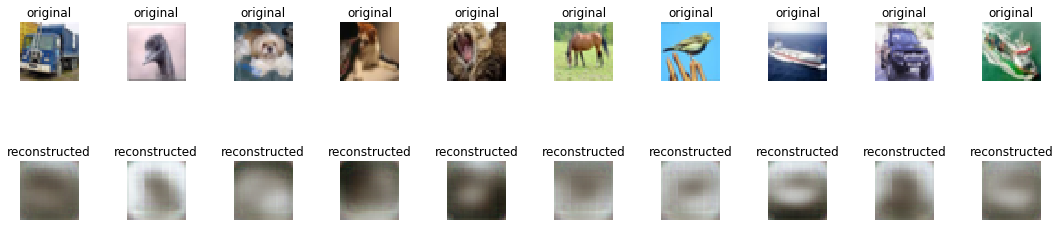

Training loss: 0.10160534202288359
Training loss: 0.09726532674752748
Training loss: 0.09612991683758222
Training loss: 0.09538180700097329
Training loss: 0.0949776505239499
Training loss: 0.09440160907613926
Training loss: 0.09416879539688429
Training loss: 0.09359910809076749
Training loss: 0.09320864700354063
Test loss: 0.09232082962989807


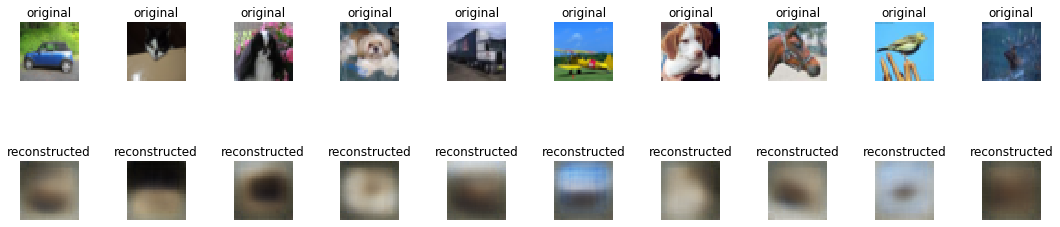

Training loss: 0.0920101458636614
Training loss: 0.09064742437539956
Training loss: 0.08998350715025877
Training loss: 0.08925732903373547
Training loss: 0.088625473739245
Training loss: 0.08781571409259087
Training loss: 0.08740556167486387
Training loss: 0.08726859085070782
Training loss: 0.08704865473585251
Training loss: 0.08677741413315138
Test loss: 0.08762536942958832


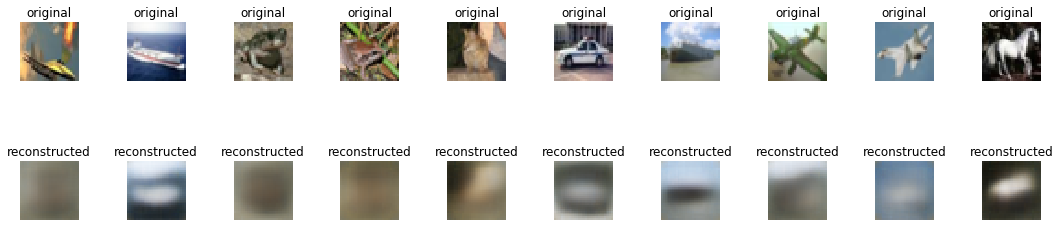

Training loss: 0.08673544652186907
Training loss: 0.08664078175639495
Training loss: 0.08643510446716578
Training loss: 0.08633208905275051
Training loss: 0.08622228279709816
Training loss: 0.08615664793894841
Training loss: 0.08602318375920638
Training loss: 0.08626232429956779
Training loss: 0.08579553056221742
Training loss: 0.08576412605933655
Test loss: 0.08806131780147552


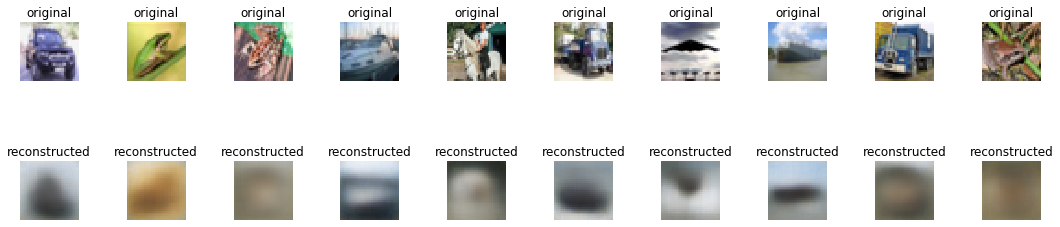

Training loss: 0.08573215917134897
Training loss: 0.08565391191305258
Training loss: 0.0856276178589234
Training loss: 0.08558627770115168
Training loss: 0.08551539144454859
Training loss: 0.08539908060278648
Training loss: 0.08550704878110152
Training loss: 0.08534142340605076
Training loss: 0.08535227613189282
Training loss: 0.08526391400358616
Test loss: 0.0865294337272644


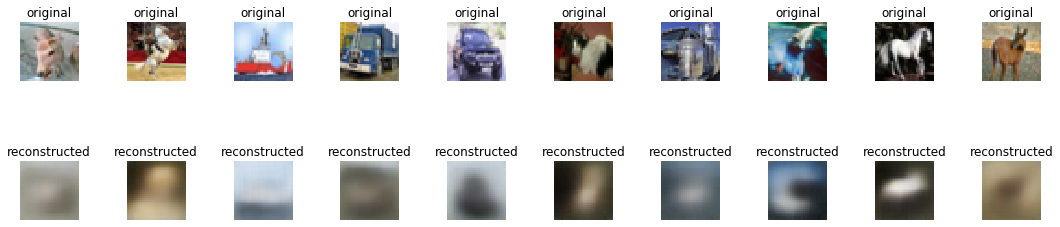

Training loss: 0.08536989476818305
Training loss: 0.08519168165631784
Training loss: 0.08509385175047776
Training loss: 0.08514814170507284
Training loss: 0.08508557195846851
Training loss: 0.08514421030114859
Training loss: 0.08499880121686519
Training loss: 0.08497711343642993
Training loss: 0.08497148824807925
Training loss: 0.08495677528090965
Test loss: 0.08726336807012558


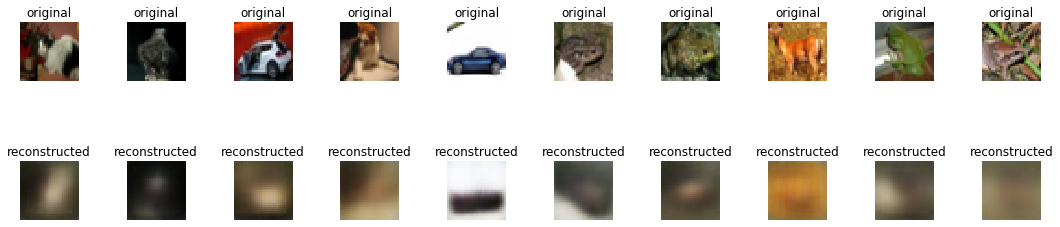

In [6]:

autoencoder = Conv_Autoencoder()

optimizer =  torch.optim.Adam(autoencoder.parameters(), lr=LR, weight_decay=1e-5)

criterion =  nn.MSELoss() 

if USE_GPU:
    autoencoder.cuda()
    criterion.cuda()

for epoch in range(N_EPOCHS):
    autoencoder.train()
    losses = []
    for (X, _) in train_loader:
        if USE_GPU:
            X = X.cuda()
        
        optimizer.zero_grad()
        
    
        reconstruction = autoencoder(X)
        
        loss = criterion(X, reconstruction)
        
        loss.backward()

        losses = np.append(losses, loss.item())

        optimizer.step()

    autoencoder.eval()

    # print loss of train set
    print('Training loss: {}'.format(np.mean(losses)))

    # evaluation on test set 
    if ((epoch+1) % 10) == 0 or epoch == 0:
        X_test, _ = next(iter(test_loader))
        if USE_GPU:
            X_test = X_test.cuda()

        with torch.no_grad():
            reconstruction_test = autoencoder(X_test)

        loss = criterion(X_test, reconstruction_test)
        print('Test loss: {}'.format(loss))

        # normalize to [0,1] for plotting
        X_test = to_img(X_test)
        reconstruction_test = to_img(reconstruction_test)
    
        # show some random images as well as some fixed images to may better see the progress
        fig, ax = plt.subplots(2, 10)
        fig.set_figwidth(15)
        fig.tight_layout()
        ax = ax.flatten()
        for i, index in enumerate(random.sample(range(len(X_test)),10)):
            img = X_test[index].cpu().numpy() 
            img_rec = reconstruction_test[index].cpu().numpy()
            ax[i].imshow(img.transpose(1,2,0))
            ax[i+10].imshow(img_rec.transpose(1,2,0))
            ax[i].set_title(f'original')
            ax[i+10].set_title(f'reconstructed')
            ax[i].set_axis_off()
            ax[i+10].set_axis_off()
        plt.show()